# Лабораторная работа

Баллы за секции:
- *Задание 1* - 10 баллов
- *Задание 2* - 20 баллов
- *Задание 3* - 30 баллов
- **Итого** - 60 баллов

Оценка за лабу $ = \frac{score}{6}$

## Внимание! Attention! Achtung!

**Данная лабораторная работа является блокирующей**, т.е. если лабораторная работа не выполнена, то оценка за курс - неуд.

Лабораторная работа считается выполненной, если **за каждое из заданий получено не менее 2 баллов**.

## Формат сдачи лабораторной работы

Данная лабораторная работа сдается так же, как и проект - заполняете данный ноутбук, отправляете его через GitHub с указанием проверяющего.

**Ассистенты не будут запускать ячейки кода, а смотреть на выведенный результат и код. Если ячейка кода не запущена - балл не ставится, даже при правильно написанном коде.**

***(Комментарии что курс по Python легче чем по C++ учтены)***

>**Примечание**
>
>Данные задания вдохновлены предметом "Введение в анализ данных" 2 курса, по итогу которого идёт отбор на DS-поток. Если вы видите себя в смежных областях, советуем выполнить данную лабораторку по максимуму.

In [4]:
# Всё необходимое для выполнения данной лабораторной работы!
import requests
from time import sleep

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Задание 1. Парсинг - 10 баллов

В этом задании Вам предстоит работать с API сайта <a target="_blank" href="hh.ru">hh.ru</a>. Документация доступна по <a target="_blank" href="https://github.com/hhru/api/blob/master/docs/vacancies.md#search">ссылке</a>.

<b><font color="red">Внимание!</font> При работе с API не забывайте делать паузы между запросами, иначе вас забанят. Просрочка дедлайна по этой причине не принимается!</b>

**Задача:**
1. выбрать 5 интересующих вас профессий (не смежных, т.е. Аналатик и Data Engineer не считается корректным)
2. затем получить доступные по данным профессиям вакансии в Москве и выделить их физические координаты
3. нанести полученные координаты на карту местоположения компаний

*Пример запроса для профессии:*

In [5]:
URL = 'https://api.hh.ru/vacancies'

params = {
    'text': "Физик-ядерщик",
    'area': 1,
    'page': 0,
    'per_page': 10
}

data = requests.get(URL, params).json()

Если Ваш запрос прошел успешно, то вы получите следующие ключи (значения данных ключей вы найдете по ссылке на документацию):

In [6]:
data.keys()

dict_keys(['items', 'found', 'pages', 'per_page', 'page', 'clusters', 'arguments', 'alternate_url'])

>**Примечание**
>
>В `data['pages']` будет хранится количество найденных страниц вакансий - для корректного сбора данных Вам нужно пробежать по **КАЖДОЙ** странице и сделать соотвествующие запросы.

>**Совет**
>
>Посмотрите что хранится в `items`!

(1 балл) Выберете для нас 5 наиболее интересных специальностей и получите по ним имеющиеся вакансии:

In [7]:
from random import randint

In [8]:
URL = 'https://api.hh.ru/vacancies'

def make_params(name, p):
  params = {
    'text': name,
    'area': 1,
    'page': p,
    'per_page': 100
  }
  return params

def count_pages(name):
  params = make_params(name, 0)
  sleep(0.8)
  data = requests.get(URL, params).json()
  return data['pages']

def get_pages(name):
  pages = count_pages(name)
  items = []
  for i in range(pages):
    params = make_params(name, i)
    sleep(0.5 + randint(1,5) * 0.1);
    data = requests.get(URL, params).json()
    items.extend(data['items'])
  return items

In [9]:
professions = ['Оператор котельной', 'Повар-сушист', 'Инженер по бурению', 'Официант в караоке', 'Физик-ядерщик']
items = []
for i in professions:
  items.append(get_pages(i))

(1 балл) Посчитайте сколько всего найдено вакансий:

In [10]:
vacancies_count = 0
for i in items:
  vacancies_count += len(i)
vacancies_count

222

(1 балл) Создайте структуру данных, которая будет хранить в себе имя компании и ее координаты (широта и долгота):

In [11]:
class Company:
  profession = ''
  name = ''
  has_coord = False
  lat = 0.0
  lng = 0.0
  def __init__(self, profession, name, has_coord, lat, lng):
    self.profession = profession
    self.name = name
    self.lat = lat
    self.lng = lng
    self.has_coord = has_coord

(1 балл) Создайте экземпляр этой структуры данных для каждой компании, которая выставила вакансию:

In [12]:
companies = []
for i in range(len(items)):
  prof = professions[i]
  item = items[i]
  for vacancy in item:
    vac_name = vacancy['employer']['name']
    if vacancy['address'] != None and vacancy['address']['lat'] != None and vacancy['address']['lng'] != None:
        vac_lat = vacancy['address']['lat']
        vac_lng = vacancy['address']['lng']
        vac_has_coord = True
    else:
        vac_has_coord = False
        vac_lat = 0.0
        vac_lng = 0.0
    companies.append(Company(prof, vac_name, vac_has_coord, vac_lat, vac_lng))


(1 балл) Найдите количество вакансий, у которых заданы координаты (значения данных может быть пустым):

In [13]:
count = 0
for comp in companies:
  if comp.has_coord == True:
    count += 1
print(count)

138


(1 балл) Отберите вакансии, которые расположены в пределах МКАД (можно грубо):

In [14]:
lats = []
lngs = []

comp_mkad = []

center_lng = 37.62
center_lat = 55.75
radius = 0.21

for comp in companies:
  if comp.has_coord == True and type(comp.lat) != None and type(comp.lng) != None:
    if ((comp.lat - center_lat)**2 + (comp.lng - center_lng)**2) < (radius**2):
      comp_mkad.append(comp)
      lats.append(comp.lat)
      lngs.append(comp.lng)


(1 балл) Постройте график в координатах "широта-долгота" для отображения вакансий внутри МКАД (не забывайте прописать прозрачность, чтобы увидеть скопления):

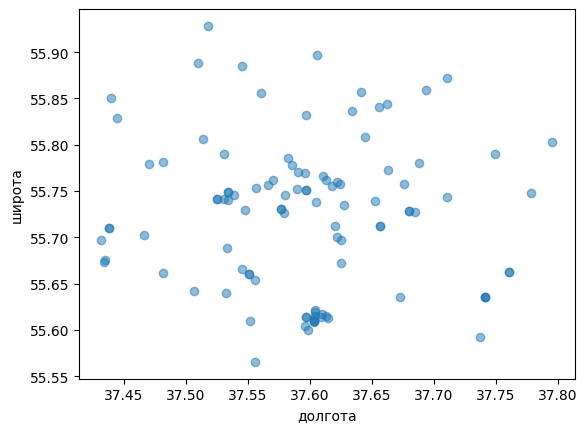

In [15]:
plt.plot(lngs, lats, 'o', alpha = 0.5)
plt.xlabel("долгота")
plt.ylabel("широта")
plt.show()

(1 балл) Нанесите все точки вакансий на карту (для этого вам поможет данная <a target="_blank" href="https://plotly.com/python/mapbox-layers/">документации</a>, не забудьте про прозрачность и центрирование по Москве): 

In [16]:
from plotly import express as px
coords = pd.DataFrame([lngs, lats]).T
fig = px.scatter_mapbox(coords, lat=1, lon=0, zoom=9, opacity=0.7)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

(2 балла) **Сделайте выводы о проделанной работе:**

>*Подсказки для маленьких: Что вы можете сказать про районы Москвы? Что вы можете сказать про зарплаты? Что вы можете сказать про спрос?*

Можно наблюдать более высокую концентрацию предложений по данным профессиям в центральных районах Москвы, а также в Южном Административном округе. В Южно-Восточном административном округе, напротив, наблюдается небольшое количество предложений.

## Задание 2. Анализ данных - 20 баллов

Вам предстоит проанализировать датасет, содержащий информацию об бриллианта, их стоимости и остальных характеристиках.



Поясним значения хранящиеся в колонках:
*   `cut` - огранка бриллианта (относится к одной из примерно 10 наиболее распространенных)
*   `color` - цвет бриллианта, прозрачные бриллианты имеют градацию `D-Z`, "более высокие" буквы - более желтоватые, но часто имеют лучшие значения, поскольку цвет трудно определить один раз в кольце
*   `clarity` - чистота бриллианта, наличие включений (внутренних дефектов), чем меньше и мельче, тем лучше
*   `carat_weight` - масса бриллианта (слабо связана с размером бриллианта, т.к. огранка и качество огранки, как правило, играют большую роль)
*   `cut_quality` - качество ограники по системе оценки GIA Cut
*   `lab` - лаборатория оценивания
*   `meas_length` - длина бриллианта
*   `meas_width` - ширина бриллианта
*   `meas_depth` - глубина бриллианта
*   `total_sales_price` - цена бриллианта в долларах.
*    **и прочие колонки**

Скачаем данные:

In [16]:
!gdown 1uIWeZFz3ElB5p1brBVEwJBHTbjXNPdfU

Downloading...
From: https://drive.google.com/uc?id=1uIWeZFz3ElB5p1brBVEwJBHTbjXNPdfU
To: /Users/olga/Desktop/diamonds.csv
100%|██████████████████████████████████████| 35.4M/35.4M [00:03<00:00, 10.3MB/s]


Создадим DataFrame:

In [17]:
diamonds = pd.read_csv("diamonds.csv")

(0.5 балла) Выведете первые 5 строк датасета:

In [18]:
diamonds.head()

,Unnamed: 0,cut,color,clarity,carat_weight,cut_quality,lab,symmetry,polish,eye_clean,...,meas_depth,girdle_min,girdle_max,fluor_color,fluor_intensity,fancy_color_dominant_color,fancy_color_secondary_color,fancy_color_overtone,fancy_color_intensity,total_sales_price
0,0,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,...,1.79,M,M,unknown,NaN,unknown,unknown,unknown,unknown,200
1,1,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Very Good,unknown,...,1.78,STK,STK,unknown,NaN,unknown,unknown,unknown,unknown,200
2,2,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,...,1.77,TN,M,unknown,NaN,unknown,unknown,unknown,unknown,200
3,3,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,...,1.78,M,STK,unknown,NaN,unknown,unknown,unknown,unknown,200
4,4,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Excellent,unknown,...,1.82,STK,STK,unknown,NaN,unknown,unknown,unknown,unknown,200


(0.5 балла) Найдите количество бриллиантов всего в данном датасете:

In [19]:
len(diamonds)

219703

(0.5 балла) Выведите максимальную и минимальную цену бриллианта в формате `номер - цена`:

In [20]:
diamonds[diamonds.total_sales_price == diamonds.total_sales_price.max()].loc[:, ['Unnamed: 0', 'total_sales_price']]


,Unnamed: 0,total_sales_price
219702,219703,1449881


In [21]:
diamonds[diamonds.total_sales_price == diamonds.total_sales_price.min()].loc[:, ['Unnamed: 0', 'total_sales_price']]

,Unnamed: 0,total_sales_price
0,0,200
1,1,200
2,2,200
3,3,200
4,4,200
5,5,200
6,6,200
7,7,200
8,8,200
9,9,200


(1 балл) Посчитайте количество пропусков (пропуском считается значение `unknown` или `None`):

In [22]:
column = diamonds.columns.tolist()
count1 = 0
for s in column:
  if 'unknown' in diamonds[s].value_counts():
    count1 += diamonds[s].value_counts()['unknown']
  if 'None' in diamonds[s].value_counts():
    count1 += diamonds[s].value_counts()['None']
count1


1746027

(1 балл) Найдите в каких столбцах присутствуют пропуски:

In [23]:
for s in column:
  if 'unknown' in diamonds[s].value_counts() or 'None' in diamonds[s].value_counts():
    print(s)

color
cut_quality
eye_clean
culet_size
culet_condition
girdle_min
girdle_max
fluor_color
fluor_intensity
fancy_color_dominant_color
fancy_color_secondary_color
fancy_color_overtone
fancy_color_intensity


В нашем датасете присутствуют колонки, которые начинаются с `fancy_color_` или `fluor_`. Большинство значений в этих колонках - `unknown` или `None`, поэтому мы считаем их малоинформативными. 

Ваша задача:

1. (0.5 балла) найти количество таких колонок, которые начинаются с `fancy_color_` или `fluor_`:

In [24]:
sum(diamonds.columns.str.startswith('fancy_color_')) + sum(diamonds.columns.str.startswith('fluor_'))

6

2. (0.5 балла) найти количество информативных (не `None` или `unknown`) значений в этих колонках: 

In [25]:
sel_columns = np.add(diamonds.columns.str.startswith('fancy_color_'), diamonds.columns.str.startswith('fluor_'))
df = diamonds.loc[:, sel_columns]

columns2 = df.columns.tolist()
count2 = 0
for s in columns2:
  if 'unknown' in df[s].value_counts():
    count2 += df[s].value_counts()['unknown']
  if 'None' in df[s].value_counts():
    count2 += df[s].value_counts()['None']
count_informative = len(df) * len(sel_columns) - count2
count_informative
      

4650787

3. (0.5 балла) удалить данные колонки из датасета, сохранив изменения (в дальнейшем работаем измененным датасетом):

In [26]:
diamonds = diamonds.loc[:, ~sel_columns]

(1 балл) Проделайте тоже самое для колонок, начинающихся с `culet_`:

In [27]:
columns_culet = diamonds.columns.str.startswith('culet_')
df2 = diamonds.loc[:, columns_culet]

columns3 = df2.columns.tolist()
count3 = 0
for s in columns3:
  if 'unknown' in df2[s].value_counts():
    count3 += df2[s].value_counts()['unknown']
  if 'None' in df2[s].value_counts():
    count3 += df2[s].value_counts()['None']
count_informative_culet = len(df2) * len(columns_culet) - count3
print(count_informative_culet)
diamonds = diamonds.loc[:, ~columns_culet]

4103936


(1 балл) Посчитайте сколько бы стоил (в тысячах долларов) сейф, в котором хранились бы все бриллианты из датасета:

In [28]:
diamonds['total_sales_price'].sum()

1517721991

Немного необоснованных манипуляций.

(1 балл) Выберите из датасета строки с четными индексами и выведете значения (не меняя нумерацию индексов):

In [29]:
diamonds.loc[((diamonds['Unnamed: 0'] % 2 == 0))]

,Unnamed: 0,cut,color,clarity,carat_weight,cut_quality,lab,symmetry,polish,eye_clean,depth_percent,table_percent,meas_length,meas_width,meas_depth,girdle_min,girdle_max,total_sales_price
0,0,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,62.7,59.0,2.85,2.87,1.79,M,M,200
2,2,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,61.1,59.0,2.88,2.90,1.77,TN,M,200
4,4,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Excellent,unknown,64.9,58.5,2.79,2.83,1.82,STK,STK,200
6,6,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Very Good,unknown,64.0,57.0,2.85,2.88,1.84,STK,STK,200
8,8,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Very Good,unknown,63.5,59.5,2.89,2.92,1.85,STK,TK,200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219693,219694,Round,E,IF,12.52,Excellent,GIA,Excellent,Excellent,unknown,62.1,58.0,14.84,14.91,9.24,unknown,unknown,1121792
219695,219696,Cushion Modified,unknown,VVS1,10.00,unknown,GIA,Very Good,Excellent,unknown,78.1,60.0,11.78,10.84,8.47,unknown,unknown,1124122
219697,219698,Oval,unknown,VS1,10.04,unknown,GIA,Excellent,Excellent,unknown,72.8,55.0,14.13,10.86,7.90,unknown,unknown,1161102
219699,219700,Radiant,unknown,VS2,5.17,unknown,GIA,Very Good,Very Good,unknown,64.8,65.0,11.55,8.81,5.71,TK,XTK,1292500


(0.5 балла) А теперь с индексами, кратными 6:

In [30]:
diamonds.loc[((diamonds['Unnamed: 0'] % 6 == 0))]

,Unnamed: 0,cut,color,clarity,carat_weight,cut_quality,lab,symmetry,polish,eye_clean,depth_percent,table_percent,meas_length,meas_width,meas_depth,girdle_min,girdle_max,total_sales_price
0,0,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,62.7,59.0,2.85,2.87,1.79,M,M,200
6,6,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Very Good,unknown,64.0,57.0,2.85,2.88,1.84,STK,STK,200
12,12,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Very Good,unknown,61.8,58.5,2.85,2.89,1.77,STK,TK,200
18,18,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,61.0,60.0,2.91,2.92,1.78,M,M,200
24,24,Round,L,I1,0.34,Excellent,IGI,Excellent,Excellent,unknown,0.0,0.0,0.00,0.00,0.00,unknown,unknown,204
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219677,219678,Round,G,VS1,10.14,Excellent,GIA,Excellent,Excellent,unknown,61.8,59.0,13.84,13.88,8.56,M,STK,851760
219683,219684,Pear,unknown,VS2,1.51,unknown,GIA,Very Good,Very Good,unknown,63.8,59.0,10.73,5.61,3.58,unknown,unknown,966401
219689,219690,Round,F,IF,10.66,Excellent,GIA,Excellent,Excellent,unknown,61.4,58.0,14.14,14.16,8.69,M,STK,1034844
219695,219696,Cushion Modified,unknown,VVS1,10.00,unknown,GIA,Very Good,Excellent,unknown,78.1,60.0,11.78,10.84,8.47,unknown,unknown,1124122


(1 балл) Выберете из датасета только категорильные признаки и выведете датасет:

In [31]:
cols = diamonds.columns
num_cols = diamonds._get_numeric_data().columns
category_cols = list(set(cols) - set(num_cols))
diamonds.loc[:, category_cols]


,cut_quality,eye_clean,girdle_max,lab,symmetry,cut,color,girdle_min,clarity,polish
0,Excellent,unknown,M,IGI,Very Good,Round,E,M,VVS2,Very Good
1,Very Good,unknown,STK,IGI,Very Good,Round,E,STK,VVS2,Very Good
2,Excellent,unknown,M,IGI,Very Good,Round,E,TN,VVS2,Very Good
3,Excellent,unknown,STK,IGI,Very Good,Round,E,M,VVS2,Very Good
4,Very Good,unknown,STK,IGI,Very Good,Round,E,STK,VVS2,Excellent
...,...,...,...,...,...,...,...,...,...,...
219698,Excellent,unknown,STK,GIA,Excellent,Round,E,M,VS1,Excellent
219699,unknown,unknown,XTK,GIA,Very Good,Radiant,unknown,TK,VS2,Very Good
219700,Excellent,unknown,M,GIA,Excellent,Round,E,TN,VS1,Excellent
219701,unknown,unknown,VTK,GIA,Good,Princess,unknown,XTN,SI2,Good


>**Примечание**
>
>Данный датасет можно использовать для задания 3 (с использованием `sklearn`)

(0.5 балла) Выберете столбец с данными о цене бриллиантов и домножите его на тот столбец, только транспонированный, и выведите полученную матрицу:

### Построение графиков

**Требования к графику:**

1.   График должен быть подписан
2.   Оси должны быть подписаны
3.   Должна быть легенда графика
4.   График должен быть информативным (желательно без сильных выбросов)

**Все надписи на русском языке!**

>**Примечание**
>
>График необходимо строить для очищенных данных - в них не должно быть пропусков по осям, по которым строите график. При этом **не перезатирайте** имеющийся датафрейм!

(2 балла) Постройте график `цвет бриллианта - стоимость`:

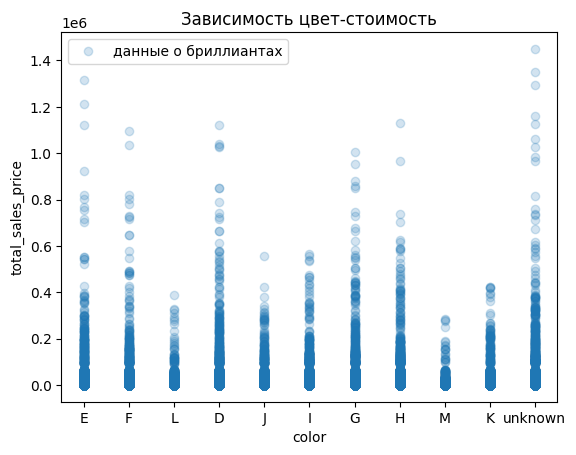

In [32]:
plt.plot(diamonds['color'], diamonds['total_sales_price'], 'o', label = 'данные о бриллиантах', alpha = 0.2,)
plt.title("Зависимость цвет-стоимость")
plt.xlabel("color")
plt.ylabel("total_sales_price")
plt.legend()
plt.show()

(2 балла) Постройте график `лабараторная оценка - кол-во бриллиантов`:

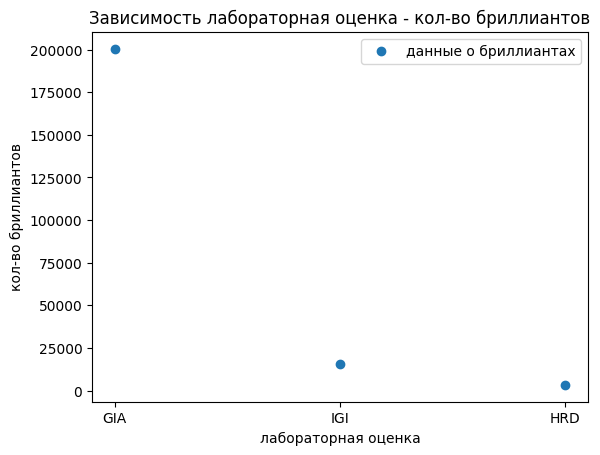

In [33]:
plt.plot(diamonds['lab'].value_counts(),'o', label = 'данные о бриллиантах')
plt.title("Зависимость лабораторная оценка - кол-во бриллиантов")
plt.xlabel("лабораторная оценка")
plt.ylabel("кол-во бриллиантов")
plt.legend()
plt.show()

(2 балла) Постройте график `вес бриллианта - стоимость`:

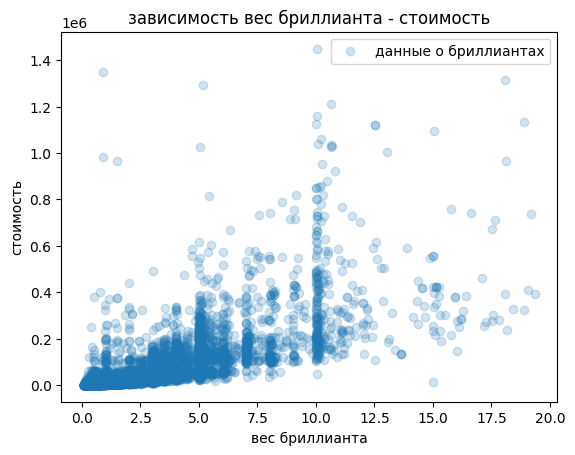

In [34]:
plt.plot(diamonds['carat_weight'], diamonds['total_sales_price'],'o', label = 'данные о бриллиантах', alpha = 0.2)
plt.title("зависимость вес бриллианта - стоимость")
plt.xlabel("вес бриллианта")
plt.ylabel("стоимость")
plt.legend()
plt.show()

(2 балла) Постройте график `система оценки GIA Cut - кол-во бриллиантов`:

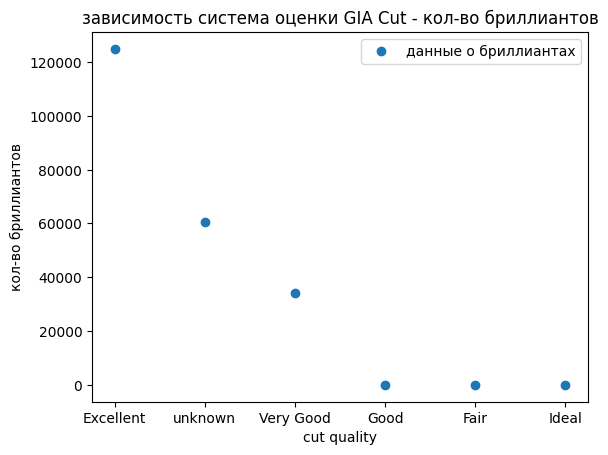

In [35]:
plt.plot(diamonds['cut_quality'].value_counts(),'o', label = 'данные о бриллиантах')
plt.title("зависимость система оценки GIA Cut - кол-во бриллиантов")
plt.xlabel("cut quality")
plt.ylabel("кол-во бриллиантов")
plt.legend()
plt.show()

(2 балла) **Сделайте выводы по построенным графикам:**

>*Подсказка для маленьких: Что вы можете сказать о графиках полученных выше для данного датасета?*

Можно увидеть в первом приближении, что есть корреляция между весом бриллианта и его стоимостью (чем больше вес, тем больше стоимость бриллианта)

Большинство сертификатов из GIA, меньшинство из HRD

Есть закономерность, что драгоценные камни определенных цветов стоят меньше, чем других цветов (так, например, цвета D, G и Н более дорогие, чем M или L)

По системе оценки GIA-cut, наибольшее число бриллиантов из данных имеют оценку "Excellent"


## Задание 3. Модель - 30 баллов

В данном задании вам предстоит построить классифицирующую модель размер алмаза и его стоимости, а затем оценить полученную модель.

>**Примечание**
>
>Данная модель не претендует на самый верный индикатор стоимости алмаза, ведь мы не учитываем ничего больше чем стоимость алмаза. Исключительно для образовательных целей :)

Для построения модели нам понадобится 4 столбца, а именно: 
- `meas_length`
- `meas_width`
- `meas_depth`
- `total_sales_price`

От остальных столбцов можно избавиться.

(1 балл) Создайте новый датасет и выведите его первые 10 строк: 

In [36]:
new_dataset = diamonds.loc[:, ['meas_length', 'meas_width', 'meas_depth', 'total_sales_price']]
new_dataset.head(10)

,meas_length,meas_width,meas_depth,total_sales_price
0,2.85,2.87,1.79,200
1,2.84,2.89,1.78,200
2,2.88,2.90,1.77,200
3,2.86,2.88,1.78,200
4,2.79,2.83,1.82,200
5,2.95,2.99,1.81,200
6,2.85,2.88,1.84,200
7,2.86,2.89,1.78,200
8,2.89,2.92,1.85,200
9,2.83,2.87,1.80,200


(1 балл) Перемешайте строки в датафрейме случайным образом: 

In [37]:
new_dataset = new_dataset.sample(frac=1)
new_dataset

,meas_length,meas_width,meas_depth,total_sales_price
174822,5.41,6.25,3.66,7161
206869,10.39,6.54,4.44,21377
146564,8.37,5.58,3.09,3626
116826,5.20,5.22,3.26,2268
164309,5.75,5.79,3.63,4861
...,...,...,...,...
191920,6.35,6.39,3.99,11300
140486,7.69,5.21,3.25,3373
99996,4.77,4.80,2.87,1600
51379,4.45,4.47,2.78,936


(1 балл) Сформируем новую колонку - для каждого бриллианта найдем сумму Минковского (p=3) по 3 измерениям бриллианта:

In [38]:
def f(row):
  val = ((row['meas_length']**3) + (row['meas_width']**3) + (row['meas_depth']**3))**(1/3)
  return val

new_dataset['mink_sum'] = new_dataset.apply(f, axis=1)
new_dataset

,meas_length,meas_width,meas_depth,total_sales_price,mink_sum
174822,5.41,6.25,3.66,7161,7.671650
206869,10.39,6.54,4.44,21377,11.418777
146564,8.37,5.58,3.09,3626,9.242857
116826,5.20,5.22,3.26,2268,6.821978
164309,5.75,5.79,3.63,4861,7.559795
...,...,...,...,...,...
191920,6.35,6.39,3.99,11300,8.341881
140486,7.69,5.21,3.25,3373,8.574911
99996,4.77,4.80,2.87,1600,6.238224
51379,4.45,4.47,2.78,936,5.837497


(1 балл) Сформируем новый датасет из двух колонок - сумма Минковского и `total_sales_price`: 

In [39]:
work_dataset = new_dataset.loc[:, ['mink_sum','total_sales_price']]
work_dataset

,mink_sum,total_sales_price
174822,7.671650,7161
206869,11.418777,21377
146564,9.242857,3626
116826,6.821978,2268
164309,7.559795,4861
...,...,...
191920,8.341881,11300
140486,8.574911,3373
99996,6.238224,1600
51379,5.837497,936


(1 балл) Разделите вашу выборку на две части в соотношении 8:2 - одна выборка будет для тренировка, а другая для тестов вашей модели:

In [44]:
import sklearn
from sklearn.model_selection import train_test_split

In [45]:
set_train, set_test = sklearn.model_selection.train_test_split(work_dataset, test_size=0.2)

In [46]:
len(set_train)

175762

In [47]:
len(set_test)

43941

(2 балла) Постройте график зависимости стоимости от вашего нового параметра размера для тренинг-выборки:

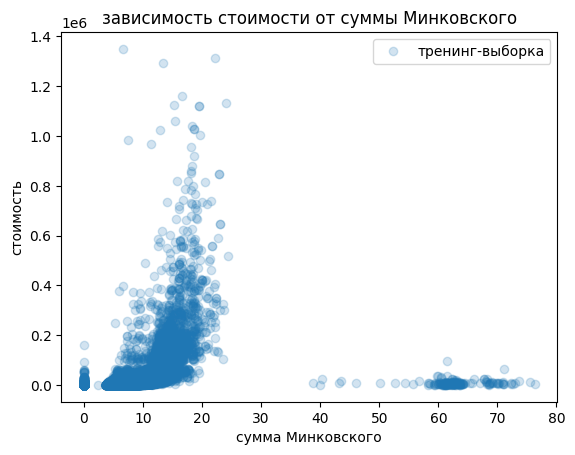

In [48]:
plt.plot(set_train['mink_sum'], set_train['total_sales_price'],'o', label = 'тренинг-выборка', alpha = 0.2)
plt.title("зависимость стоимости от суммы Минковского")
plt.xlabel("сумма Минковского")
plt.ylabel("стоимость")
plt.legend()
plt.show()

(2 балла) Нанесите на тот же график тестовую выборку, используя другой цвет (не забудьте про параметр прозрачности):

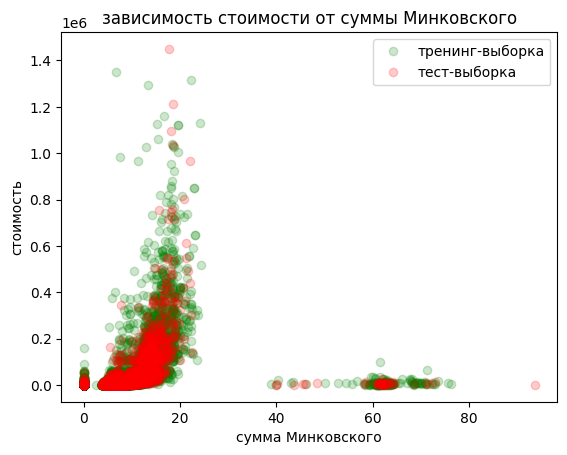

In [49]:
plt.plot(set_train['mink_sum'], set_train['total_sales_price'],'o', label = 'тренинг-выборка', alpha = 0.2, color = 'g')
plt.plot(set_test['mink_sum'], set_test['total_sales_price'],'o', label = 'тест-выборка', alpha = 0.2, color = 'r')
plt.title("зависимость стоимости от суммы Минковского")
plt.xlabel("сумма Минковского")
plt.ylabel("стоимость")
plt.legend()
plt.show()

(3 балла) Найдите для каждой бриллианта из тестовой выборки его "ближайшего соседа" из тренинг-выборки. Для каждого бриллианта из тестовой выборки найдите расстояния до соответствующего ближайшего соседа:

In [ ]:
# your code here

(3 балла) Найдите насколько сильно (в процентах) отличается цена бриллиантов из тестовой выборки от их соответствующих ближайших соседей:

In [ ]:
# your code here

**Данная модель является выдумкой автора. Не важен коэффициент ошибки, важны ваши шаги для получения коэффициента.**

### Введение в машинное обучение

Теперь давайте познакомимся с таким сильным инструментом как `sklearn`.

Вам необходимо:
1. выбрать 2 категориальных признака
2. на их основе обучить решающее дерево
3. оценить среднеквадратичную ошибку цены бриллианта
4. сделать пп. 1-3 и выбрать ту пару, которая дает лучший результат
5. сделать выводы

(3 балла) Мы работаем с категориальными признаками, для них не понятно что есть "больше" и "меньше". Поэтому нам нужно предварительно закодировать значения наших признаков, с чем нам поможет [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html):

In [ ]:
# your code here

(3 балла) Разбейте датасет на обучающую и тестовую выбору. Для этого вам поможет [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html):

In [ ]:
# your code here

(3 балла) Затем создайте и обучите вашу модель - [DecisionTreeRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html):

In [ ]:
# your code here

(3 балла) Оцените ошибку вашей модели при помощи [mean_squared_error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html):

In [ ]:
# your code here

(3 балла) **Сделайте выводы какие категориальные признаки лучше:**

*Подсказки для маленьких: Что вы можете сказать о зависимости по вашей выборке признаков? Какой вы можете сделать вывод об готовых инструментах для работы и написанных Вами?*

Ваши выводы здесь :)